# Endgame

## Importing Libraries

In [1]:
!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

## Web Scraping & Preprocessing

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [3]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
toronto.to_csv('toronto1.csv')
toronto.head()

,Postalcode,Borough,Neighborhood
0,0,0,0
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


### Removing 'Not Assigned and Null Values"

In [4]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
toronto.head()
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Some Descriptive Statistics of the data

In [5]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4N,North York,Downsview
freq,1,24,4


In [6]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [7]:
df_2.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Getting the Latitude and Longitude of the neighborhoods

In [8]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

### Adding the latitude and longitude to the previous dataframe

In [9]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']
df_2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


## Data Visualization

### Creating the map of Scarborough

In [10]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="Week 5-The Battle of Neighborhoods:Endgame")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [11]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="Week 5-The Battle of Neighborhoods:Endgame")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude

### Getting Neighborhood data from Four Square API

In [12]:
# @hiddel_cell
CLIENT_ID = '3VNXDSVWRLXXORNDRX5JSZ0N5QCKHYRXZPLCGAJ3RGG04JCZ' # my Foursquare ID
CLIENT_SECRET = 'HN4R2S1YPUO1B33YWRJSMWRCXWFNQOWJXCLJLAO3TBVS0KRB' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3VNXDSVWRLXXORNDRX5JSZ0N5QCKHYRXZPLCGAJ3RGG04JCZ
CLIENT_SECRET: HN4R2S1YPUO1B33YWRJSMWRCXWFNQOWJXCLJLAO3TBVS0KRB


In [13]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [14]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Nearby venues to Scarborough

In [16]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
3,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


### Category of these nearby venues

In [17]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
3,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


### Finding the top ten category of venues

In [18]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        7
Coffee Shop           5
Restaurant            5
Gas Station           2
Italian Restaurant    2
Pharmacy              2
Intersection          2
Department Store      2
Sandwich Place        2
Shopping Mall         1
Name: categories, dtype: int64

### Getting the latitude and longitude of nearby venues

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

### Finding the details of unique venues in Scarborough

In [21]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 302 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,19,19,19,19,19,19
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",14,14,14,14,14,14
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


### Encoding the categorical values using OneHotEncoding

In [22]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(10)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Finding the 5 most popular venues for all neighborhoods

In [23]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]    

---- Agincourt ----
                venue  freq
0  Chinese Restaurant  0.11
1       Shopping Mall  0.11
2     Bubble Tea Shop  0.05
3      Sandwich Place  0.05
4          Print Shop  0.05


---- Alderwood, Long Branch ----
         venue  freq
0          Pub  0.12
1          Gym  0.12
2  Coffee Shop  0.12
3  Pizza Place  0.12
4     Pharmacy  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
                 venue  freq
0                 Park  0.14
1          Pizza Place  0.14
2          Coffee Shop  0.14
3  Fried Chicken Joint  0.07
4       Sandwich Place  0.07


---- Bayview Village ----
                             venue  freq
0       Construction & Landscaping  0.25
1                            Trail  0.25
2                      Flower Shop  0.25
3                             Park  0.25
4  Molecular Gastronomy Restaurant  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.12
1      Sandwich Place  0.08
2         Cof

### Creating a new dataset with most common venues near neighborhoods

In [24]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Breakfast Spot,Coffee Shop,Pizza Place,Supermarket,Sushi Restaurant,Latin American Restaurant,Sandwich Place,Bank
1,"Alderwood, Long Branch",Gym,Pharmacy,Print Shop,Pub,Convenience Store,Gas Station,Pizza Place,Coffee Shop,Doner Restaurant,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Park,Pizza Place,Mediterranean Restaurant,Fried Chicken Joint,Sandwich Place,Intersection,Sushi Restaurant,Restaurant,Deli / Bodega
3,Bayview Village,Construction & Landscaping,Flower Shop,Park,Trail,Yoga Studio,Elementary School,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Indian Restaurant,Butcher,Juice Bar,Sports Club,Thai Restaurant,Restaurant


## Hyperparameter Tuning(Finding best value of K for model)

In [25]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Scarborough_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [26]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)

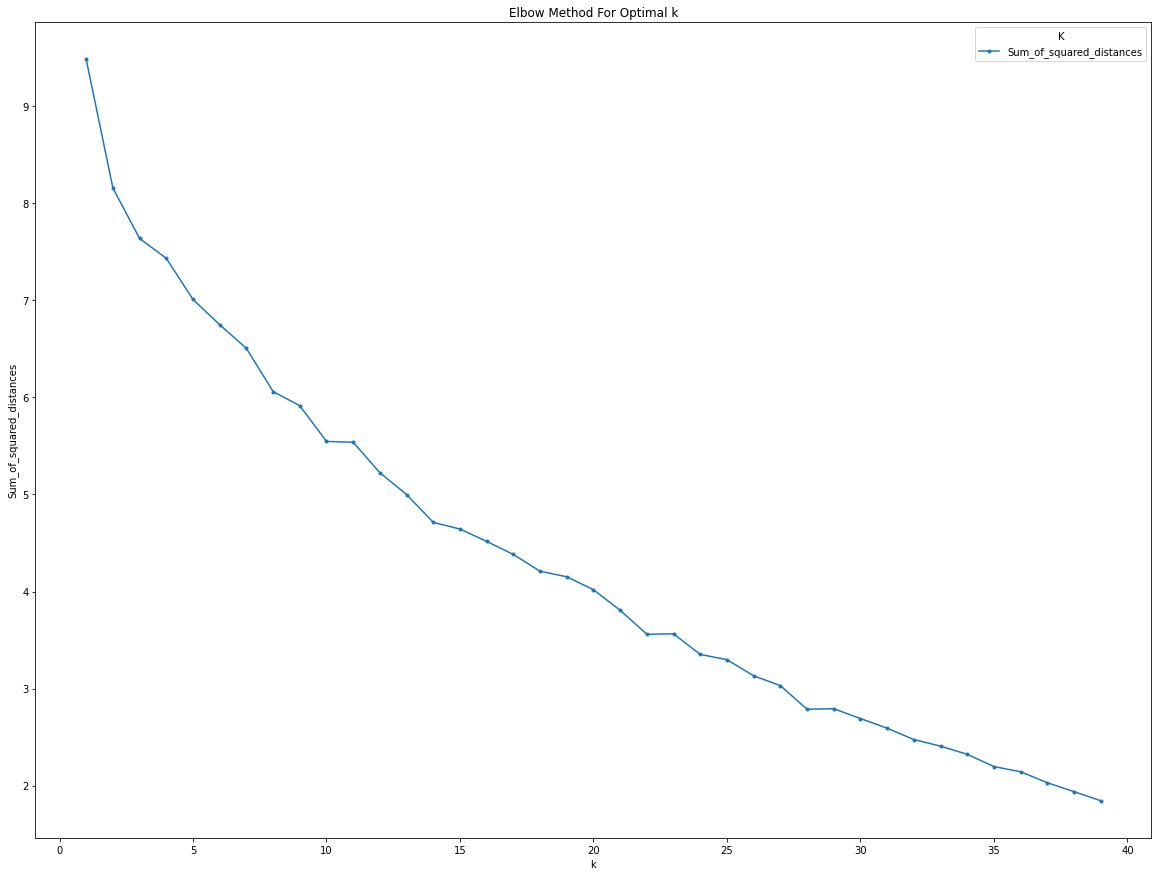

In [27]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Optimal K is 15

In [28]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=15, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([ 7,  5,  7, 11,  7,  1,  1,  1,  1,  1,  3,  1,  7,  1,  7,  1,  7,
        7,  1,  7,  7,  1,  7,  3,  7,  7, 11,  7,  7,  1,  1,  1,  7,  1,
       12,  1,  7, 14,  6,  1, 11,  7,  7,  1,  1,  0,  7,  1,  7,  1,  9,
       10,  7, 11, 11,  3,  1,  7,  7,  7,  7,  7,  2,  1,  1,  1, 11,  4,
        8,  7, 13,  7,  7,  1,  7,  7,  1,  7,  7,  1,  7,  7,  7,  7,  1,
        1,  5,  3,  5,  7,  5,  7,  7,  7, 14,  7,  1,  2], dtype=int32)

In [29]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

#exporting the final and processed dataset
Scarborough_merged.to_csv('final_data')

In [30]:
kclusters = 15

In [31]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#5c38fd', '#386df9', '#149df1', '#12c8e6', '#37e6d8', '#5af8c8', '#80ffb4', '#a4f89f', '#c8e688', '#ecc86f', '#ff9d53', '#ff6d38', '#ff381c', '#ff0000']


In [32]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df4=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 3,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df5=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 4,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df6=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 5,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df7=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 6,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df8=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 7,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df9=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 8,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df10=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 9,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df11=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 10,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df12=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 11,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df13=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 12,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df14=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 13,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df15=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 14,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]


### Getting the Scarborough Housing Prices

In [33]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              ]})

In [34]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

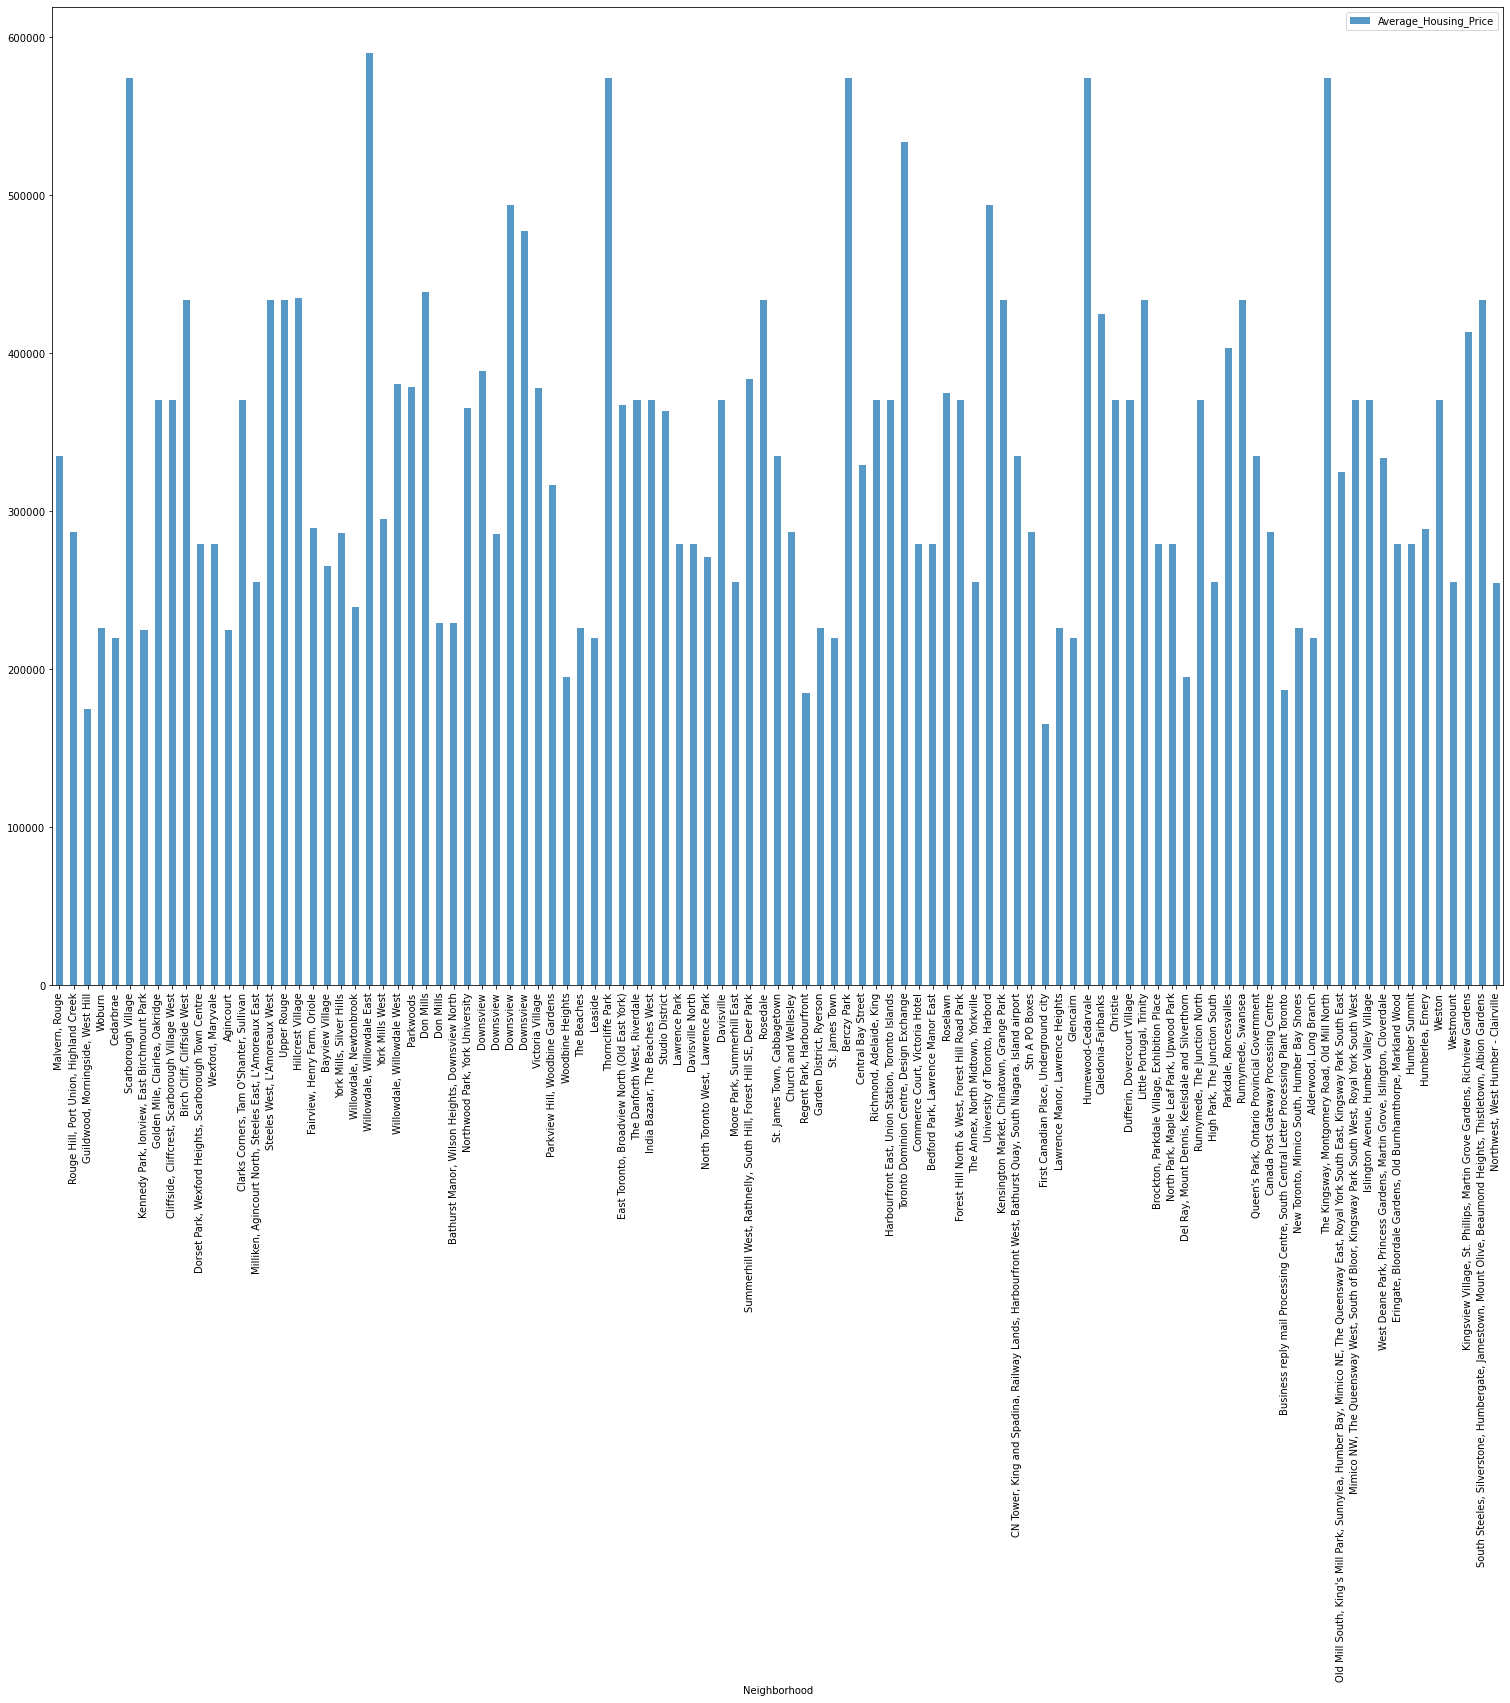

In [36]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(26,18),alpha=0.75)

### School rating per clusters

In [37]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"],
                      "Cluster4":df4["Neighborhood"],
                      "Cluster5":df5["Neighborhood"],
                      "Cluster6":df6["Neighborhood"],
                      "Cluster7":df7["Neighborhood"],
                      "Cluster8":df8["Neighborhood"],
                      "Cluster9":df9["Neighborhood"],
                      "Cluster10":df10["Neighborhood"],
                      "Cluster11":df11["Neighborhood"],
                      "Cluster12":df12["Neighborhood"],
                      "Cluster13":df13["Neighborhood"],
                      "Cluster14":df14["Neighborhood"],
                      "Cluster15":df15["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [38]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [39]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

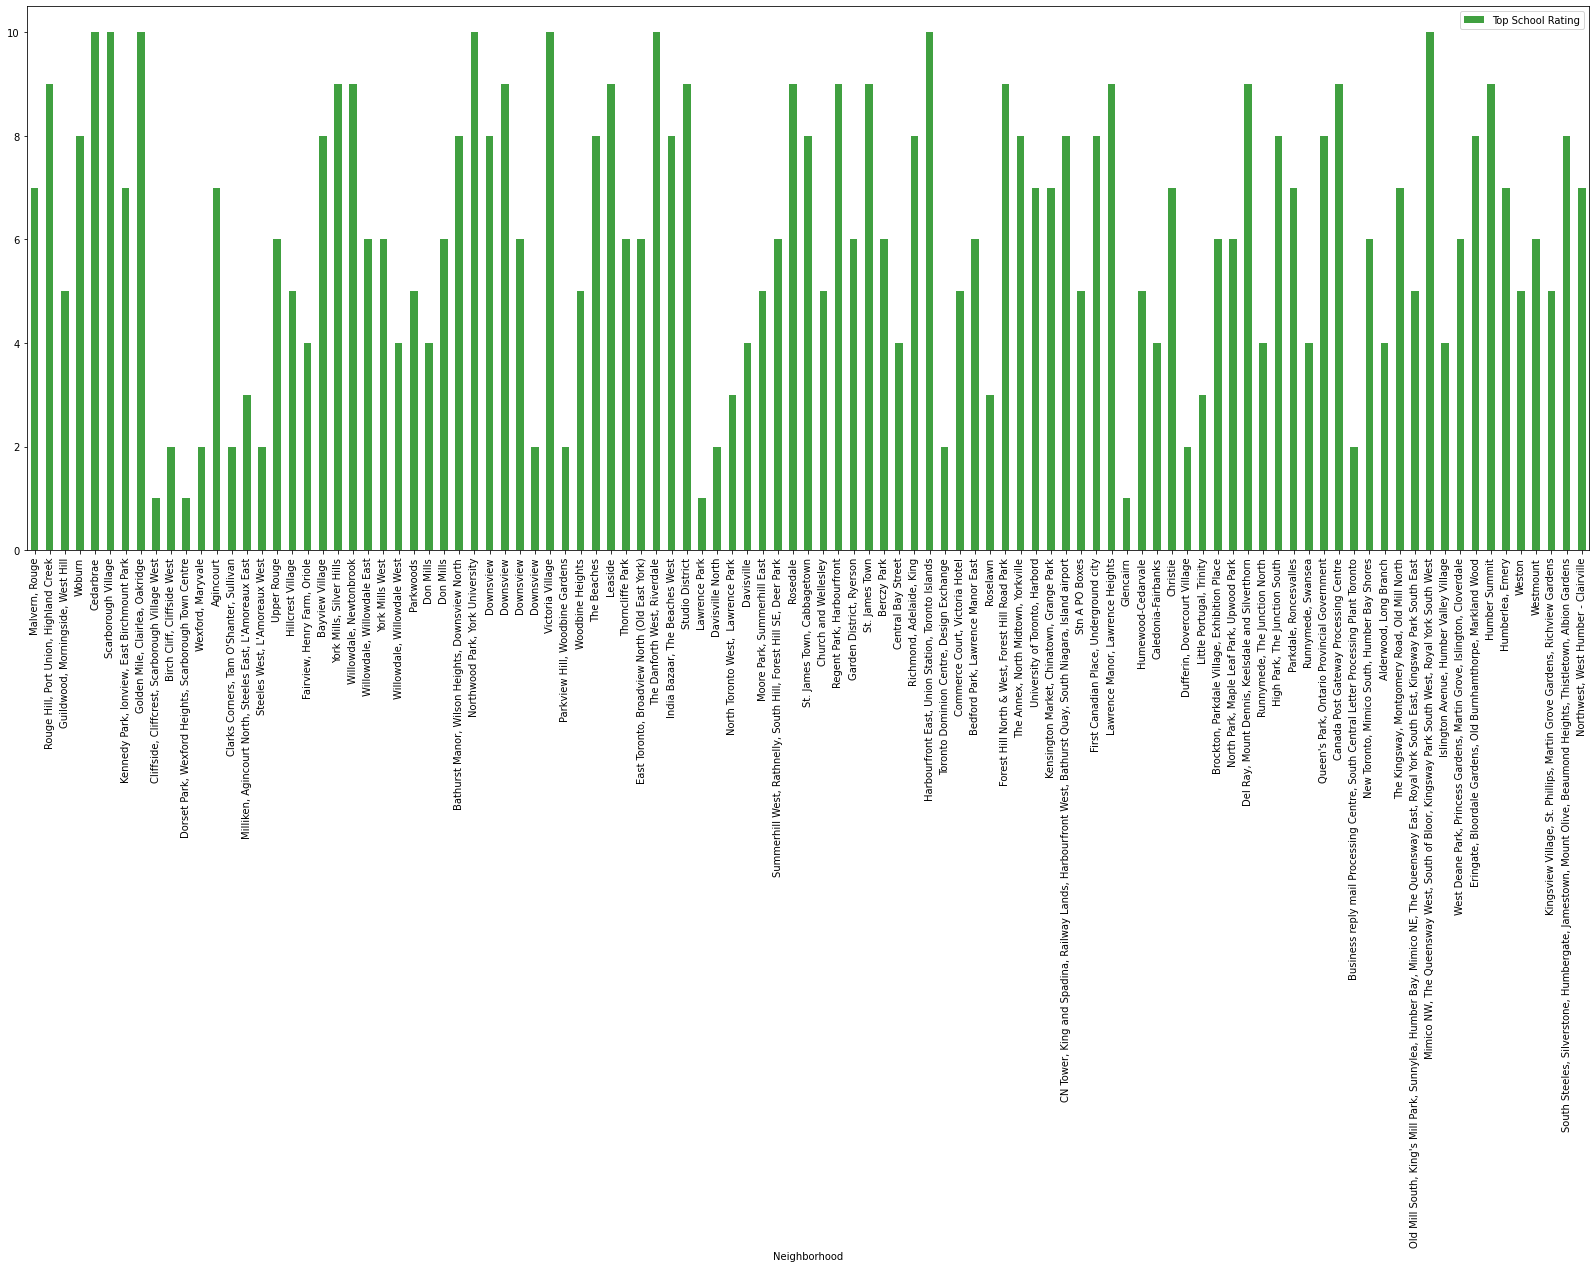

In [41]:
Scarborough_school_ratings.plot(kind='bar',figsize=(28,10),color='green',alpha=0.75);

### Conclusion

<b>In this project, using k-means cluster algorithm the neighborhood were seperated into 15 different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.</b>